
**Time series: Prediction of future interest in topic using Facebook's Prophet Library**

## Import

We retrieve the dataset with the interest over time of the keyword "data science" since 2004 in the US from [trends.google.com](https://trends.google.com/trends/?geo=US). <br>

The numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
#!pip install prophet
from prophet import Prophet

df = pd.read_csv('https://drive.google.com/uc?export=download&id=1GTup48HKTMqT9ZWI02vG65thl7zEBPLK')
df

,Month,data science: (United States)
0,2004-01,17
1,2004-02,13
2,2004-03,11
3,2004-04,6
4,2004-05,6
...,...,...
195,2020-04,82
196,2020-05,80
197,2020-06,78
198,2020-07,77


## Preprocessing

Facebook'Prophet library requires the dataframe to have a `ds` (datetime) and `y` columns

In [16]:
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2004-01-01,17
1,2004-02-01,13
2,2004-03-01,11
3,2004-04-01,6
4,2004-05-01,6


## Plotting the data

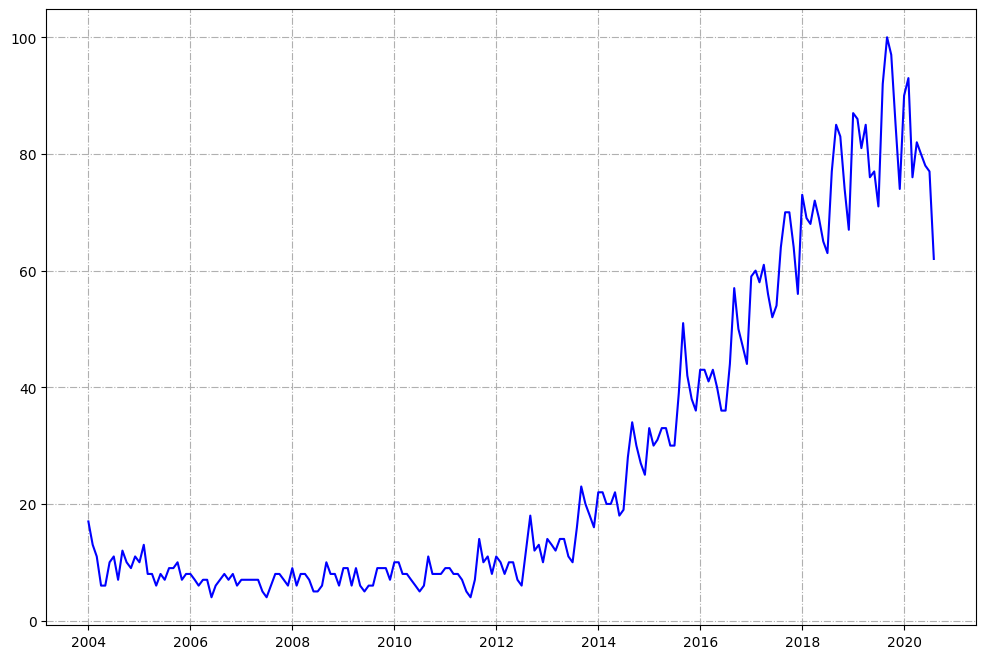

In [17]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(df['ds'], df['y'], 'b')
plt.show()

## Train-test split
* 176 months train (88%)
* 24 months test

In [18]:
train = df.iloc[:176]
test = df.iloc[176:]
train.shape, test.shape

((176, 2), (24, 2))

## Fit the data

Facebook's Prophet library

In [20]:
model = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
model.fit(train)

12:24:21 - cmdstanpy - INFO - Chain [1] start processing
12:24:21 - cmdstanpy - INFO - Chain [1] done processing


## Forecast


In [22]:
horizon = 36
future = model.make_future_dataframe(periods=horizon, freq='MS') #placeholder dataframe to hold predictions
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
207,2021-04-01,109.277004,103.028147,115.766838
208,2021-05-01,102.490129,96.323810,108.631295
209,2021-06-01,93.953706,88.445051,100.227142
210,2021-07-01,93.477102,87.303370,99.679666
211,2021-08-01,113.179363,105.893899,120.663427


## Plot forecast

* Using [`model.plot(forecast)`](https://facebook.github.io/prophet/docs/quick_start.html)

* Shaded region represents the 95% uncertainty interval

* Black dots represent the original data


In [25]:
ax = model.plot(forecast);

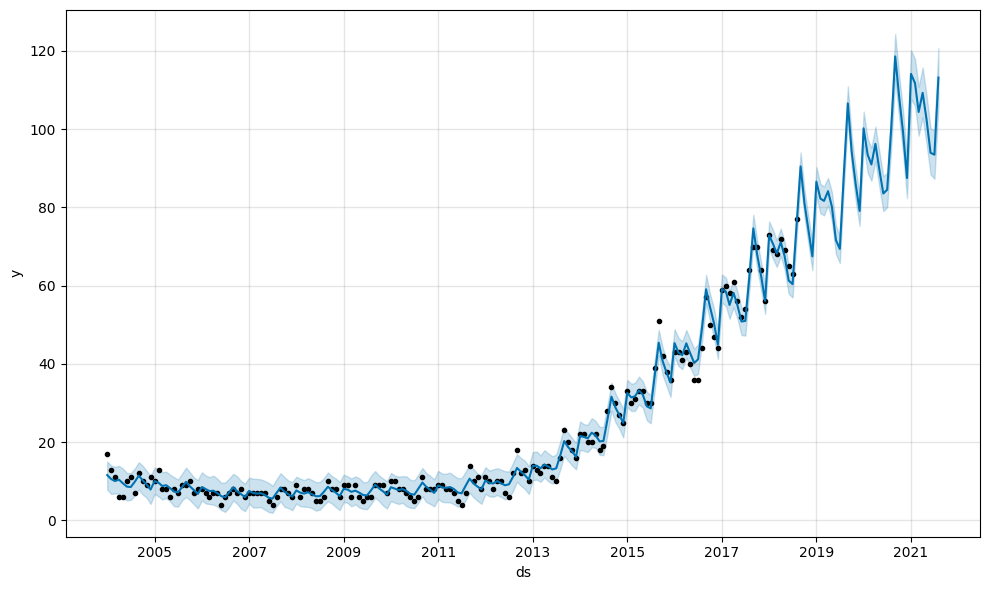

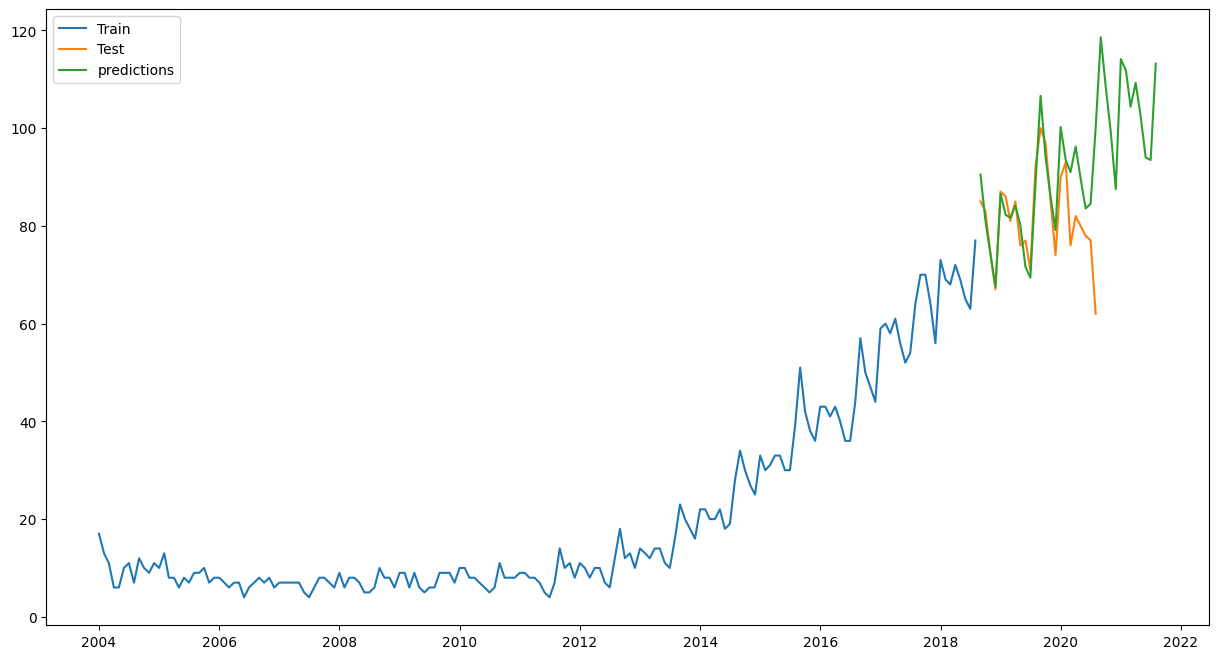

In [24]:
plt.figure(figsize=(15, 8))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Test")
plt.plot(forecast[-horizon:]['ds'], forecast[-horizon:]['yhat'], label="predictions")
plt.legend(loc="best")
plt.show()

## Plot trend and yearly seasonality of the time series.

* Use the `plot_components()` function from Facebook's Prophet Library

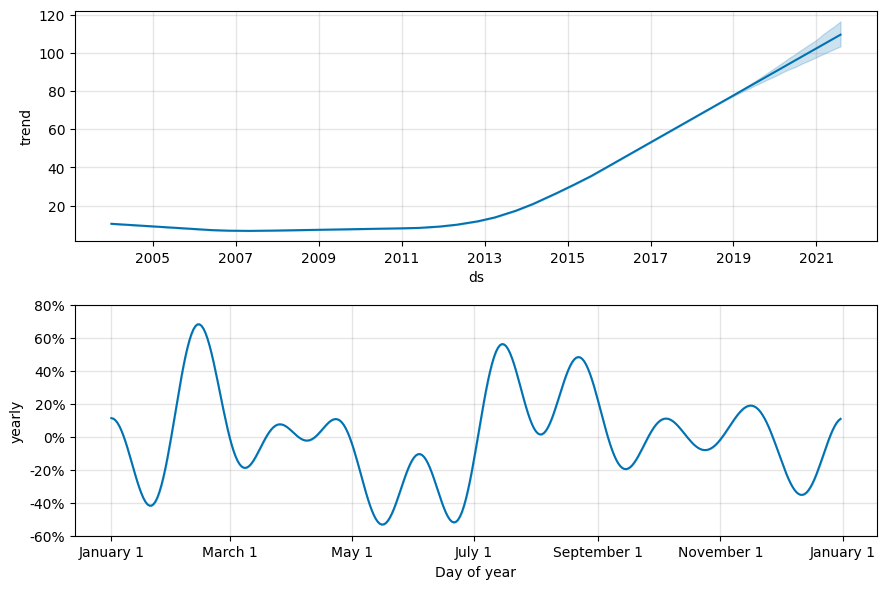

In [27]:
model.plot_components(forecast)

## Evaluating the model with cross-validation!


Evaluate with Time Series K-fold CV with
- train sets of size 5 years
- horizon val sizes of 1 year
- shifting each fold by 180 days

In [28]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [29]:
cv_results = cross_validation(model=model, initial=f'{365 * 5} days', horizon='365 days', period='180 days')
cv_results

  0%|          | 0/18 [00:00<?, ?it/s]

12:31:21 - cmdstanpy - INFO - Chain [1] start processing
12:31:22 - cmdstanpy - INFO - Chain [1] done processing
12:31:22 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:23 - cmdstanpy - INFO - Chain [1] done processing
12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing
12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:24 - cmdstanpy - INFO - Chain [1] done processing
12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing
12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2009-04-01,5.751318,3.722324,7.902540,9,2009-03-16
1,2009-05-01,5.326924,3.285579,7.305745,6,2009-03-16
2,2009-06-01,5.545936,3.483260,7.578633,5,2009-03-16
3,2009-07-01,5.753378,3.828709,7.929701,6,2009-03-16
4,2009-08-01,5.892882,3.824206,7.960061,6,2009-03-16
...,...,...,...,...,...,...
211,2018-04-01,69.294789,65.719724,72.876381,72,2017-08-01
212,2018-05-01,65.561687,61.885372,68.990329,69,2017-08-01
213,2018-06-01,57.005809,53.629264,60.285702,65,2017-08-01
214,2018-07-01,56.937480,53.192406,60.500166,63,2017-08-01


In [30]:
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,18.390697,4.288438,3.555583,0.164577,0.141773,0.182401,0.428571
1,40 days,20.152740,4.489180,3.819253,0.175714,0.148686,0.196279,0.380952
2,42 days,18.783441,4.333987,3.676889,0.166928,0.148686,0.184666,0.380952
3,45 days,19.853553,4.455733,3.823556,0.166798,0.148686,0.184509,0.333333
4,46 days,18.171785,4.262838,3.570807,0.159757,0.141773,0.175935,0.380952
...,...,...,...,...,...,...,...,...
165,359 days,37.364965,6.112689,4.848457,0.200231,0.153913,0.236676,0.333333
166,360 days,40.461948,6.360971,5.227661,0.205692,0.153913,0.242544,0.285714
167,361 days,40.125191,6.334445,5.134007,0.202960,0.153913,0.239951,0.309524
168,364 days,39.868481,6.314149,5.086825,0.198937,0.153913,0.236127,0.333333


In [31]:
from prophet.plot import plot_cross_validation_metric

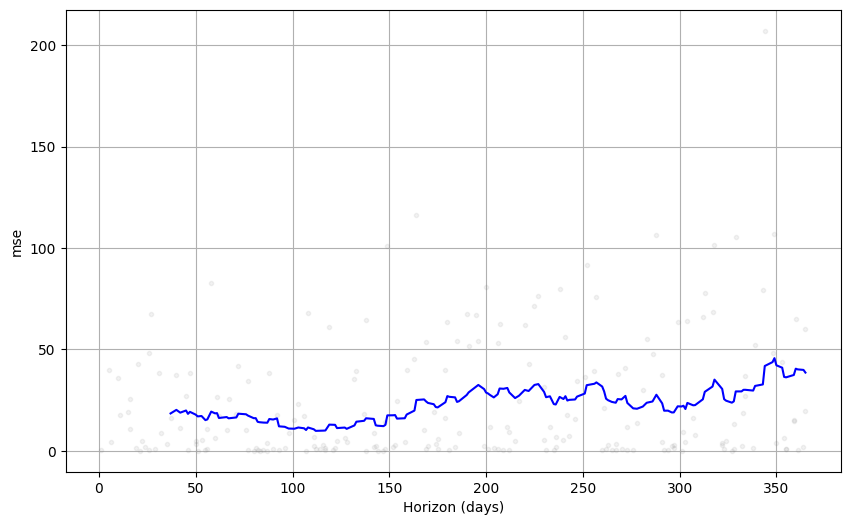

In [34]:
# Plot results below
plot_cross_validation_metric(cv_results, metric='mse')